# I-JEPA Masking Visualization

Visualize how patches, context blocks, and target blocks work.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from matplotlib.patches import Rectangle

from jepax.model.ijepa import get_2d_sincos_pos_embed
from jepax.data.datasets import build_dataset
from jepax.masks import MaskCollator

In [2]:
loader, num_classes, n_samples, img_size = build_dataset(
    "celeba",
    data_dir="~/data",
    batch_size=16,
    is_train=True,
    img_size=224,
    max_samples=16,
)
print(f"Image size: {img_size}, Attributes: {num_classes}, Samples: {n_samples}")

images, labels = next(iter(loader))
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Image size: 224, Attributes: 40, Samples: 16
Batch shape: (16, 224, 224, 3)
Labels shape: (16, 40)


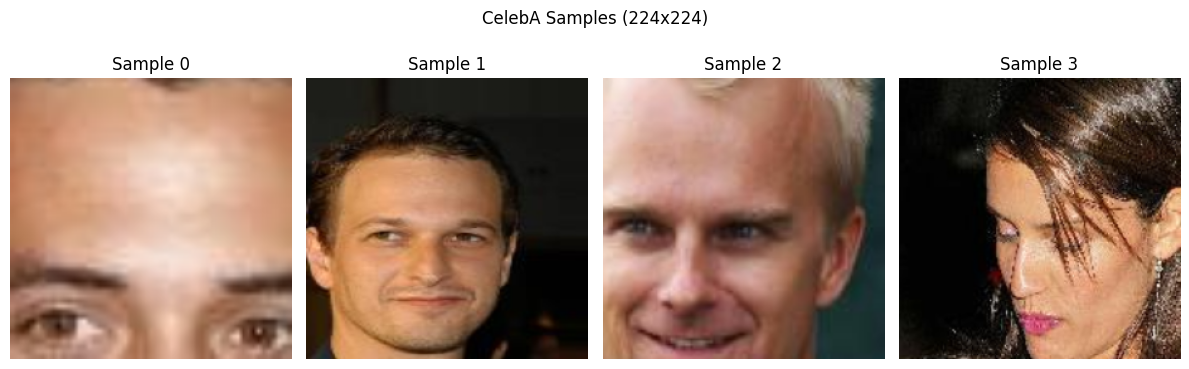

In [3]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
for i, ax in enumerate(axes):
    ax.imshow(images[i])
    ax.set_title(f"Sample {i}")
    ax.axis("off")
plt.suptitle(f"CelebA Samples ({img_size}x{img_size})")
plt.tight_layout()

## Patchify

In [4]:
PATCH_SIZE = 14
IMG_SIZE = img_size
GRID_SIZE = IMG_SIZE // PATCH_SIZE
N_PATCHES = GRID_SIZE**2

print(f"Patch size: {PATCH_SIZE}x{PATCH_SIZE}")
print(f"Grid: {GRID_SIZE}x{GRID_SIZE} = {N_PATCHES} patches")

Patch size: 14x14
Grid: 16x16 = 256 patches


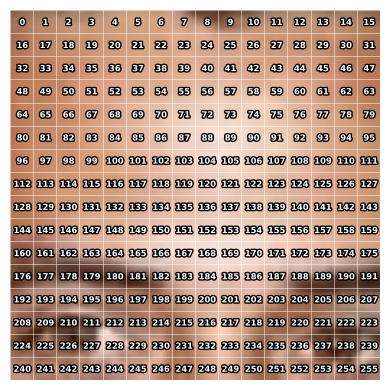

In [5]:
def show_patch_grid(img, patch_size, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))

    ax.imshow(img)

    h, w = img.shape[:2]
    grid_h, grid_w = h // patch_size, w // patch_size

    for i in range(grid_h + 1):
        ax.axhline(i * patch_size - 0.5, color="white", linewidth=0.5, alpha=0.7)
    for j in range(grid_w + 1):
        ax.axvline(j * patch_size - 0.5, color="white", linewidth=0.5, alpha=0.7)

    for i in range(grid_h):
        for j in range(grid_w):
            idx = i * grid_w + j
            ax.text(
                j * patch_size + patch_size / 2,
                i * patch_size + patch_size / 2,
                str(idx),
                color="white",
                fontsize=6,
                ha="center",
                va="center",
                fontweight="bold",
                path_effects=[pe.withStroke(linewidth=2, foreground="black")],
            )

    ax.axis("off")
    return ax


fig, ax = plt.subplots(figsize=(4, 4))
show_patch_grid(images[0], PATCH_SIZE, ax)
plt.tight_layout()
plt.show()

In [6]:
mask_collator = MaskCollator(
    img_size=IMG_SIZE,
    patch_size=PATCH_SIZE,
)

rng = np.random.default_rng(0)
enc_masks, pred_masks = mask_collator(rng, batch_size=1)

# enc_masks: [B, n_enc, L_enc], pred_masks: [B, n_pred, L_pred]
ctx_indices = enc_masks[0, 0]  # First sample, first encoder mask
tgt_blocks = [pred_masks[0, i] for i in range(pred_masks.shape[1])]

print(f"Context patches: {len(ctx_indices)}")
print(f"Number of target blocks: {len(tgt_blocks)}")
for i, block in enumerate(tgt_blocks):
    print(f"  Block {i}: {len(block)} patches")

Context patches: 104
Number of target blocks: 4
  Block 0: 42 patches
  Block 1: 42 patches
  Block 2: 42 patches
  Block 3: 42 patches


Image: (224, 224, 3), range [0.01, 1.00]
Grid: 16x16, Patch: 14x14
Context: 104, Target blocks: [42, 42, 42, 42]
Note: Target blocks overlap by 32 patches


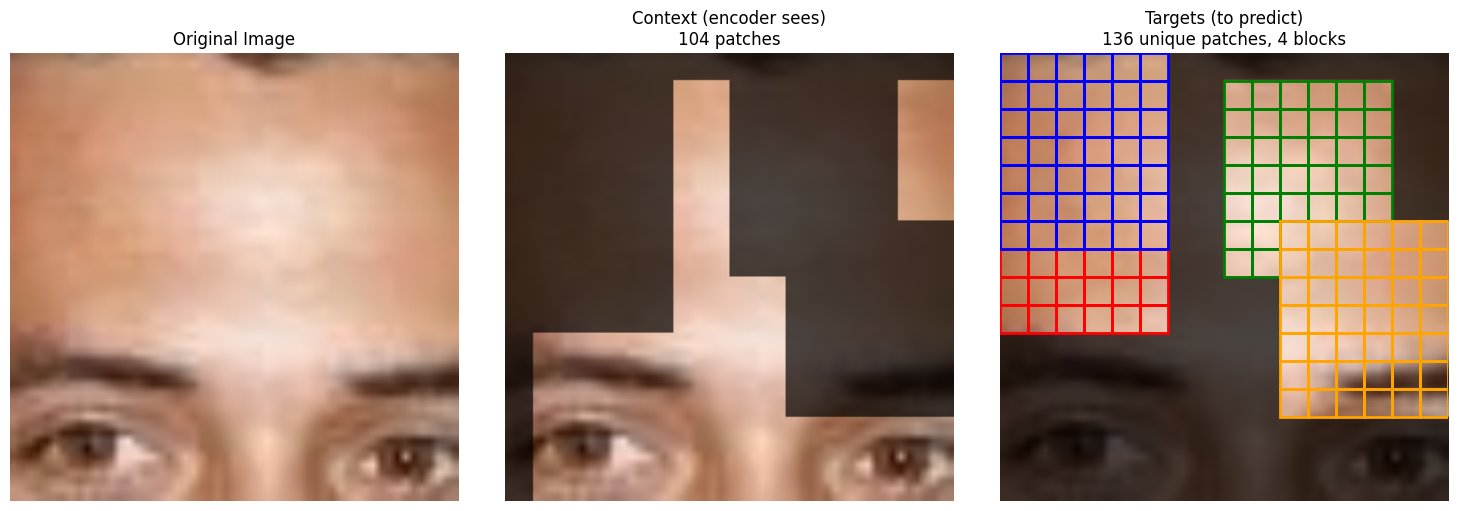

In [7]:
def visualize_masks(img, ctx_indices, tgt_blocks, patch_size, grid_size):
    img = np.asarray(img, dtype=np.float32)
    if img.max() > 1.0:
        img = img / 255.0

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    ctx_set = set(int(x) for x in ctx_indices)
    all_tgt = set()
    for block in tgt_blocks:
        all_tgt.update(int(x) for x in block)

    overlap = ctx_set & all_tgt
    assert not overlap

    total_tgt_patches = sum(len(b) for b in tgt_blocks)
    tgt_overlap = total_tgt_patches - len(all_tgt)
    if tgt_overlap > 0:
        print(f"Note: Target blocks overlap by {tgt_overlap} patches")

    axes[0].imshow(img)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    ctx_img = img.copy()
    for idx in range(grid_size * grid_size):
        if idx not in ctx_set:
            i, j = idx // grid_size, idx % grid_size
            y0, y1 = i * patch_size, (i + 1) * patch_size
            x0, x1 = j * patch_size, (j + 1) * patch_size
            ctx_img[y0:y1, x0:x1] *= 0.3
    axes[1].imshow(ctx_img)
    axes[1].set_title(f"Context (encoder sees)\n{len(ctx_set)} patches")
    axes[1].axis("off")

    tgt_img = img.copy() * 0.3
    for idx in all_tgt:
        i, j = idx // grid_size, idx % grid_size
        y0, y1 = i * patch_size, (i + 1) * patch_size
        x0, x1 = j * patch_size, (j + 1) * patch_size
        tgt_img[y0:y1, x0:x1] = img[y0:y1, x0:x1]
    axes[2].imshow(tgt_img)

    colors = ["red", "blue", "green", "orange"]
    for b_idx, block in enumerate(tgt_blocks):
        for idx in block:
            i, j = int(idx) // grid_size, int(idx) % grid_size
            rect = Rectangle(
                (j * patch_size - 0.5, i * patch_size - 0.5),
                patch_size,
                patch_size,
                linewidth=2,
                edgecolor=colors[b_idx % len(colors)],
                facecolor="none",
            )
            axes[2].add_patch(rect)
    axes[2].set_title(
        f"Targets (to predict)\n{len(all_tgt)} unique patches, {len(tgt_blocks)} blocks"
    )
    axes[2].axis("off")

    plt.tight_layout()
    return fig


print(f"Image: {images[0].shape}, range [{images[0].min():.2f}, {images[0].max():.2f}]")
print(f"Grid: {GRID_SIZE}x{GRID_SIZE}, Patch: {PATCH_SIZE}x{PATCH_SIZE}")
print(f"Context: {len(ctx_indices)}, Target blocks: {[len(b) for b in tgt_blocks]}")

visualize_masks(images[0], ctx_indices, tgt_blocks, PATCH_SIZE, GRID_SIZE)
plt.show()

In [8]:
# ctx_indices, tgt_blocks

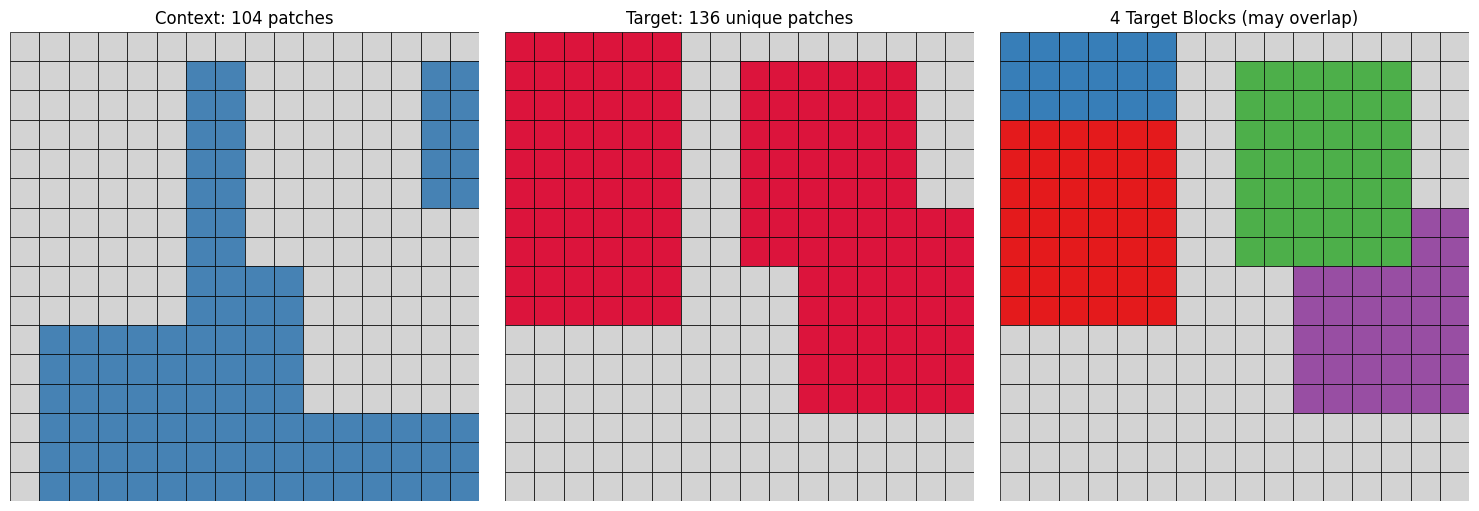

In [9]:
tgt_idx = np.unique(np.concatenate(tgt_blocks))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Adjust font size based on grid - skip text if too many patches
show_text = GRID_SIZE <= 10
fontsize = max(4, 10 - GRID_SIZE // 2)

ax = axes[0]
ctx_set = set(ctx_indices.tolist())
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        idx = i * GRID_SIZE + j
        facecolor = "steelblue" if idx in ctx_set else "lightgray"
        rect = Rectangle(
            (j, GRID_SIZE - 1 - i),
            1,
            1,
            facecolor=facecolor,
            edgecolor="black",
            linewidth=0.5,
        )
        ax.add_patch(rect)
        if show_text:
            ax.text(
                j + 0.5,
                GRID_SIZE - 0.5 - i,
                str(idx),
                ha="center",
                va="center",
                fontsize=fontsize,
                color="white" if idx in ctx_set else "black",
            )
ax.set_xlim(0, GRID_SIZE)
ax.set_ylim(0, GRID_SIZE)
ax.set_aspect("equal")
ax.set_title(f"Context: {len(ctx_set)} patches")
ax.axis("off")

ax = axes[1]
tgt_set = set(tgt_idx.tolist())
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        idx = i * GRID_SIZE + j
        facecolor = "crimson" if idx in tgt_set else "lightgray"
        rect = Rectangle(
            (j, GRID_SIZE - 1 - i),
            1,
            1,
            facecolor=facecolor,
            edgecolor="black",
            linewidth=0.5,
        )
        ax.add_patch(rect)
        if show_text:
            ax.text(
                j + 0.5,
                GRID_SIZE - 0.5 - i,
                str(idx),
                ha="center",
                va="center",
                fontsize=fontsize,
                color="white" if idx in tgt_set else "black",
            )
ax.set_xlim(0, GRID_SIZE)
ax.set_ylim(0, GRID_SIZE)
ax.set_aspect("equal")
ax.set_title(f"Target: {len(tgt_set)} unique patches")
ax.axis("off")

ax = axes[2]
colors = ["#e41a1c", "#377eb8", "#4daf4a", "#984ea3"]
for i in range(GRID_SIZE):
    for j in range(GRID_SIZE):
        idx = i * GRID_SIZE + j
        facecolor = "lightgray"
        for b_idx, block in enumerate(tgt_blocks):
            if idx in block.tolist():
                facecolor = colors[b_idx % len(colors)]
                break
        rect = Rectangle(
            (j, GRID_SIZE - 1 - i),
            1,
            1,
            facecolor=facecolor,
            edgecolor="black",
            linewidth=0.5,
        )
        ax.add_patch(rect)
        if show_text:
            ax.text(
                j + 0.5,
                GRID_SIZE - 0.5 - i,
                str(idx),
                ha="center",
                va="center",
                fontsize=fontsize,
                color="white" if facecolor != "lightgray" else "black",
            )
ax.set_xlim(0, GRID_SIZE)
ax.set_ylim(0, GRID_SIZE)
ax.set_aspect("equal")
ax.set_title(f"{len(tgt_blocks)} Target Blocks (may overlap)")
ax.axis("off")

plt.tight_layout()
plt.show()

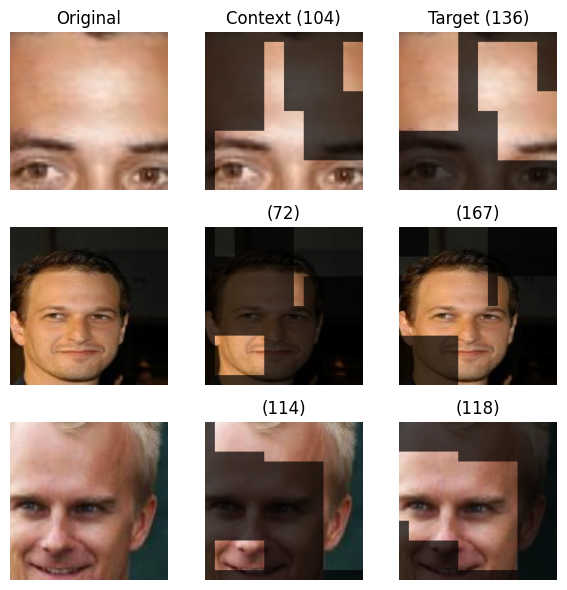

In [10]:
fig, axes = plt.subplots(3, 3, figsize=(6, 6))

for row in range(3):
    # Convert to float32 for proper visualization
    img = np.asarray(images[row], dtype=np.float32)
    if img.max() > 1.0:
        img = img / 255.0

    rng = np.random.default_rng(row * 100)
    enc_masks, pred_masks = mask_collator(rng, batch_size=1)

    ctx_idx = enc_masks[0, 0]
    tgt_blocks = [pred_masks[0, i] for i in range(pred_masks.shape[1])]

    ctx_set = set(ctx_idx.tolist())
    all_tgt = set()
    for block in tgt_blocks:
        all_tgt.update(block.tolist())

    # Original
    axes[row, 0].imshow(img)
    axes[row, 0].set_title("Original" if row == 0 else "")
    axes[row, 0].axis("off")

    # Context - dim non-context patches (multiply by 0.3, not set to 0.3)
    ctx_img = img.copy()
    for i in range(GRID_SIZE):
        for j in range(GRID_SIZE):
            if i * GRID_SIZE + j not in ctx_set:
                ctx_img[
                    i * PATCH_SIZE : (i + 1) * PATCH_SIZE,
                    j * PATCH_SIZE : (j + 1) * PATCH_SIZE,
                ] *= 0.3
    axes[row, 1].imshow(ctx_img)
    axes[row, 1].set_title(
        f"Context ({len(ctx_set)})" if row == 0 else f"({len(ctx_set)})"
    )
    axes[row, 1].axis("off")

    # Target - show only target patches, dim everything else
    tgt_img = img.copy() * 0.3
    for idx in all_tgt:
        i, j = idx // GRID_SIZE, idx % GRID_SIZE
        tgt_img[
            i * PATCH_SIZE : (i + 1) * PATCH_SIZE, j * PATCH_SIZE : (j + 1) * PATCH_SIZE
        ] = img[
            i * PATCH_SIZE : (i + 1) * PATCH_SIZE, j * PATCH_SIZE : (j + 1) * PATCH_SIZE
        ]
    axes[row, 2].imshow(tgt_img)
    axes[row, 2].set_title(
        f"Target ({len(all_tgt)})" if row == 0 else f"({len(all_tgt)})"
    )
    axes[row, 2].axis("off")

plt.tight_layout()
plt.show()

## Positional Embeddings

I-JEPA uses 2D sinusoidal positional embeddings. Row and column are encoded separately, then concatenated. This is how the model knows the spatial relationship between patches.

In [11]:
EMBED_DIM = 128
pos_embed = get_2d_sincos_pos_embed(EMBED_DIM, GRID_SIZE)
print(f"Position embeddings shape: {pos_embed.shape}")
print(f"{N_PATCHES} patches, each with {EMBED_DIM}-dim encoding")

Position embeddings shape: (256, 128)
256 patches, each with 128-dim encoding


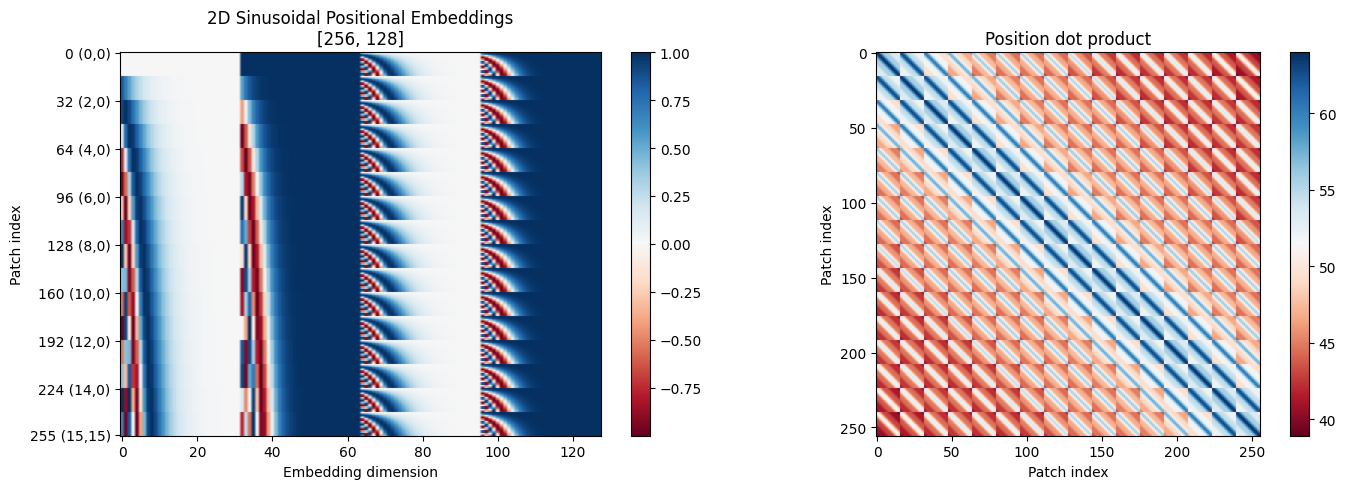

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
im = ax.imshow(pos_embed, aspect="auto", cmap="RdBu")
ax.set_xlabel("Embedding dimension")
ax.set_ylabel("Patch index")
ax.set_title(f"2D Sinusoidal Positional Embeddings\n[{N_PATCHES}, {EMBED_DIM}]")

n_ticks = min(8, GRID_SIZE)
tick_step = N_PATCHES // n_ticks
yticks = [i * tick_step for i in range(n_ticks)] + [N_PATCHES - 1]
ylabels = [f"{idx} ({idx // GRID_SIZE},{idx % GRID_SIZE})" for idx in yticks]
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels)
plt.colorbar(im, ax=ax)

ax = axes[1]
similarity = pos_embed @ pos_embed.T
im = ax.imshow(similarity, cmap="RdBu")
ax.set_xlabel("Patch index")
ax.set_ylabel("Patch index")
ax.set_title("Position dot product")
plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()